# Updated version (ver.1.2)

- ver.1

> step 1. Find the position of defects

> step 2. Enumerate separated regions

> step 3. Calculate SEMU of defects on different region

- ver.1.2

> step 1. Find both white Mura and black Mura

> step 2. Enumerate separated regions

> step 3. Calculate SEMU (background brightness is different for each defect, considering regional difference)


## 1. Find both white Mura and black Mura

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

enter image name: w (1)


(256, 256)

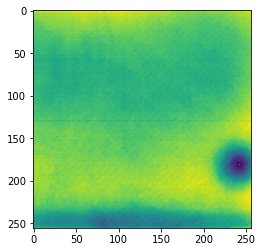

In [60]:
x = input('enter image name: ')

fname = f'./mura images/{x}.bmp'
#fname = "/home/cov/Desktop/PML/project1_Mura/AUO_Data/JND_RAW_DATA/C5A02VC/C5A02VC_C3_2_PM_L48_FMura.tif"
img = cv2.imread(fname, 0)
#plt.imshow(img, cmap='gray')#, vmin=0, vmax=255)
imgFloat = img.astype('float')# =np.float32(img)
coeff = cv2.dct(imgFloat)
coeff[:,3:]=0
coeff[3:][:]=0
reconsImg = cv2.idct(coeff)
#plt.imshow(reconsImg)
diff = reconsImg-img
plt.imshow(diff)
img.shape

0


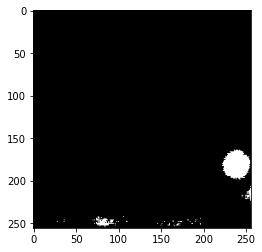

In [66]:
diff_n = cv2.normalize(diff, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
thresh1 = cv2.adaptiveThreshold(diff_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,65,50)# obtain white Mura
thresh2 = cv2.adaptiveThreshold(diff_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 65,-50)# obtain black Mura
BothT = thresh1+thresh2
plt.imshow(BothT, cmap='gray', vmin=0, vmax=255)
print(BothT[20,20])

(256, 256)

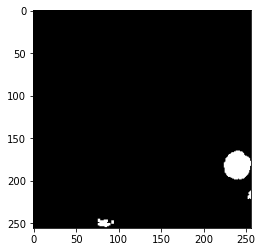

In [67]:
BothT2 = cv2.medianBlur(BothT, 3)
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(BothT2, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray', vmin=0, vmax=255)
opening.shape

## 2. Enumerate separated regions

No.0 defect:


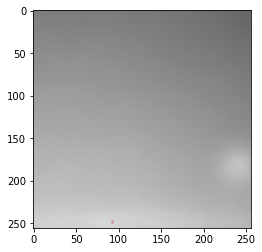

No.1 defect:


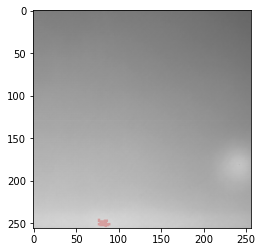

No.2 defect:


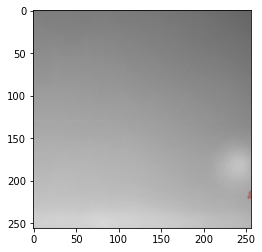

No.3 defect:


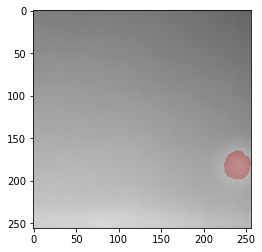

In [68]:
color = (255,200,200)#(200,200,200)
lst_dfcts = []
lst_bdbox = []
bdRect = []

_, opening2 = cv2.threshold(opening, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(opening2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# drawing = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    cimg,cimg2 = np.zeros_like(opening), np.zeros_like(opening)
    cv2.drawContours(cimg, contours, i, color, -1, cv2.LINE_8)#, hierarchy, 0)
    # cv2.drawContours(drawing, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    pts = np.where(cimg == 255)
    lst_dfcts.append(img[pts[0], pts[1]]) # record the intensity at the defect pixels
    bdRect.append(cv2.boundingRect(contours[i]))
    cv2.rectangle(cimg2, (int(bdRect[i][0]), int(bdRect[i][1])),\
                  (int(bdRect[i][0]+bdRect[i][2]), int(bdRect[i][1]+bdRect[i][3])), 255, -1)
    pts2 = np.where(cimg2 == 255)
    lst_bdbox.append(img[pts2[0], pts2[1]])
    
for j in range(len(lst_dfcts)):
    drawing2 = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(drawing2, contours, j, color, -1, cv2.LINE_8)#, hierarchy, 0) # -1 doesn't count the boundary
    for i in range(3): # overlay
        drawing2[:,:,i] = drawing2[:,:,i]+img
    
    print("No.{} defect:".format(j))
    plt.imshow(drawing2)
    plt.show()
#print(len(lst_dfcts),"\t",drawing2.shape)

# 3. Calculate SEMU
## Calculate regional background intensity

Create a bounding box around the defect, the residual region is accounted for the background intensity.

![How to calculate background intensity](a1.png)

In [69]:
# bdbox_pixel_count = img.shape[0]*img.shape[1]
# total_intens = cv2.sumElems(img)[0] - defect_intens

I_Back = [] #total_intens/(total_pixel_count-defect_pixel_count)

for i in range(len(lst_dfcts)):
#     bdbox_pixel_count = bdRect[i][2]*bdRect[i][3] # does boundary pixel overlaps defects pixel?
#     bdbox_intens = 
#     defect_pixel_count = len(lst_dfcts[i])
#     defect_intens = sum(lst_dfcts[i]) # locally sum the intensity of defect
    I_Back.append((sum(lst_bdbox[i])-sum(lst_dfcts[i]))/(len(lst_bdbox[i])-len(lst_dfcts[i])))

C_i = []
C_jnd_i = []
Semu_i = []

for i in range(len(lst_dfcts)):
    C_i.append(abs(I_Back[i]-sum(lst_dfcts[i])/len(lst_dfcts[i]))/I_Back[i]*100)
    C_jnd_i.append(1.97/(len(lst_dfcts[i])**0.33) + 0.72)
    Semu_i.append(C_i[i]/C_jnd_i[i])


---------------------------
No.0 defect, Semu = 0.4577710423326189


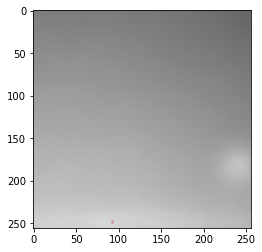

---------------------------
No.1 defect, Semu = 0.9449161432553205


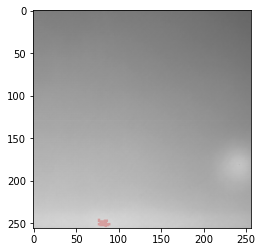

---------------------------
No.2 defect, Semu = 0.42464796758066403


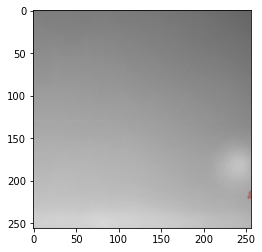

---------------------------
No.3 defect, Semu = 6.186312222800796


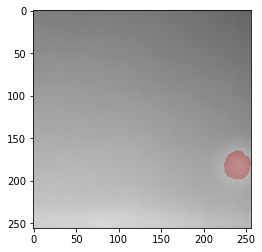

In [70]:
for j in range(len(lst_dfcts)):
    drawing2 = np.zeros((opening.shape[0], opening.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(drawing2, contours, j, color, -1, cv2.LINE_8)#, hierarchy, 0) # -1 doesn't count the boundary
    for i in range(3): # overlay
        drawing2[:,:,i] = drawing2[:,:,i]+img
    
    print("---------------------------\nNo.{} defect, Semu = {}".format(j,Semu_i[j]))
    plt.imshow(drawing2)
    plt.show()

In [10]:
I_Back

[140.4278350515464]

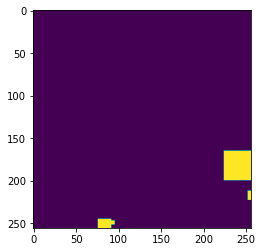

In [71]:
cimg,cimg2 = np.zeros_like(opening), np.zeros_like(opening)
for i in range(len(contours)):
    cv2.drawContours(cimg, contours, i, color, -1, cv2.LINE_8)#, hierarchy, 0)
    # cv2.drawContours(drawing, contours, i, color, -1, cv2.LINE_8, hierarchy, 0)
    pts = np.where(cimg == 255)
    lst_dfcts.append(img[pts[0], pts[1]]) # record the intensity at the defect pixels
    bdRect.append(cv2.boundingRect(contours[i]))
    cv2.rectangle(cimg2, (int(bdRect[i][0]), int(bdRect[i][1])),\
                  (int(bdRect[i][0]+bdRect[i][2]), int(bdRect[i][1]+bdRect[i][3])), 255, -1)
    pts2 = np.where(cimg2 == 255)
    lst_bdbox.append(img[pts2[0], pts2[1]])
    plt.imshow(cimg2)

---
---

In [12]:
len(lst_dfcts[2])

IndexError: list index out of range

In [560]:
bdRect[0]

(0, 200, 256, 1)

In [561]:
print(sum(lst_bdbox[0]))
print(sum(lst_dfcts[0]))

128256
64256


In [569]:
print(len(lst_bdbox[0])) # 484 = 22 x 22
print(len(lst_dfcts[0]))

512
256
